# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Открываем файл с данными и изучаем общую информацию

In [1]:
!pip install category_encoders

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import os
import seaborn as sns

import lightgbm as lgb # импорт библиотеки LightGBM
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

import category_encoders as ce

In [3]:
# проверим версию LightGBM
print("Версия LightGBM      : ", lgb.__version__)

Версия LightGBM      :  3.3.1


In [4]:
# чтение файлов с данными
pth1 = '/datasets/autos.csv'

pth1_local = 'C:/Users/Alexandra' + pth1
    
if os.path.exists(pth1):
    data = pd.read_csv(pth1) 
    
elif os.path.exists(pth1_local):
    data = pd.read_csv(pth1_local)

else:
    print('Файлы не найдены')

In [5]:
#Выводим первые 5 строчек датафрейма на экран
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
#Выводим основную информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
# Проверяем пропущенные значения
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('YlOrRd')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


**Вывод:**

В выборке **data** 354369 строк, 16 столбцов. Имеются пропуски в столбцах:

- VehicleType (тип автомобильного кузова)
- Gearbox (тип коробки передач)
- Model (модель автомобиля)
- FuelType (тип топлива)
- Repaired (была машина в ремонте или нет)

### Проверяем аномальные значения

In [8]:
data['NumberOfPictures'].unique() # Проверяем уникальные значения NumberOfPictures

array([0])

Столбец **NumberOfPictures** неинформативный.

In [9]:
# Проверяем уникальные значения RegistrationYear
unique_local_name = set(data['RegistrationYear'].unique())
unique_local_name

{1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

Проверим год, когда была создана последняя анкета.

In [10]:
# Проверяем уникальные значения DateCreated
unique_local_name = set(data['DateCreated'].unique())
unique_local_name

{'2014-03-10 00:00:00',
 '2015-03-20 00:00:00',
 '2015-06-18 00:00:00',
 '2015-08-07 00:00:00',
 '2015-08-10 00:00:00',
 '2015-09-04 00:00:00',
 '2015-09-09 00:00:00',
 '2015-11-02 00:00:00',
 '2015-11-08 00:00:00',
 '2015-11-10 00:00:00',
 '2015-11-12 00:00:00',
 '2015-11-17 00:00:00',
 '2015-11-23 00:00:00',
 '2015-11-24 00:00:00',
 '2015-12-05 00:00:00',
 '2015-12-06 00:00:00',
 '2015-12-17 00:00:00',
 '2015-12-27 00:00:00',
 '2015-12-30 00:00:00',
 '2016-01-02 00:00:00',
 '2016-01-03 00:00:00',
 '2016-01-06 00:00:00',
 '2016-01-07 00:00:00',
 '2016-01-08 00:00:00',
 '2016-01-10 00:00:00',
 '2016-01-13 00:00:00',
 '2016-01-15 00:00:00',
 '2016-01-16 00:00:00',
 '2016-01-17 00:00:00',
 '2016-01-18 00:00:00',
 '2016-01-19 00:00:00',
 '2016-01-20 00:00:00',
 '2016-01-22 00:00:00',
 '2016-01-23 00:00:00',
 '2016-01-24 00:00:00',
 '2016-01-25 00:00:00',
 '2016-01-26 00:00:00',
 '2016-01-27 00:00:00',
 '2016-01-28 00:00:00',
 '2016-01-29 00:00:00',
 '2016-01-30 00:00:00',
 '2016-01-31 00:

Последняя запись была сделана в 2016 году. Первые машины массового производства появились в 1900 году. Будем считать, что год регистрации меньше 1900  и больше 2016 - ошибочные.

In [11]:
data = data.loc[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1900)]

In [12]:
# Проверяем уникальные значения RegistrationYear
unique_local_name = set(data['RegistrationYear'].unique())
unique_local_name

{1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016}

Столбец **NumberOfPictures** имеет только нулевые значения. Удалим его. Также для моделей не понадобятся столбцы:
- **DateCrawled** (дата скачивания анкеты из базы)
- **RegistrationMonth** (месяц регистрации автомобиля)
- **DateCreated** (дата создания анкеты)
- **PostalCode** (почтовый индекс владельца анкеты (пользователя))
- **LastSeen** (дата последней активности пользователя)

Они не влияют на стоимость автомобиля. Удаляем.

In [13]:
#удалим столбцы, которые нам не понадобятся
data = data.drop(['NumberOfPictures', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339773 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             339773 non-null  int64 
 1   VehicleType       316859 non-null  object
 2   RegistrationYear  339773 non-null  int64 
 3   Gearbox           321864 non-null  object
 4   Power             339773 non-null  int64 
 5   Model             322148 non-null  object
 6   Kilometer         339773 non-null  int64 
 7   FuelType          312524 non-null  object
 8   Brand             339773 non-null  object
 9   Repaired          274974 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.5+ MB


In [15]:
# Проверяем уникальные значения Price
unique_local_name = set(data['Price'].unique())
unique_local_name

{0,
 1,
 2,
 3,
 4,
 5,
 8198,
 8199,
 8200,
 9,
 8,
 16390,
 12,
 13,
 14,
 10,
 16400,
 17,
 15,
 16399,
 20,
 16,
 19,
 8211,
 24,
 25,
 21,
 8219,
 27,
 29,
 30,
 8222,
 32,
 33,
 8225,
 35,
 7,
 8230,
 39,
 40,
 38,
 45,
 16430,
 47,
 8240,
 49,
 50,
 8245,
 55,
 8248,
 8249,
 8250,
 59,
 60,
 11,
 58,
 8255,
 16445,
 16449,
 16450,
 65,
 8258,
 69,
 70,
 66,
 8265,
 74,
 75,
 77,
 8270,
 79,
 80,
 8275,
 85,
 8280,
 88,
 90,
 16475,
 89,
 8282,
 18,
 95,
 16480,
 8288,
 98,
 99,
 100,
 8290,
 101,
 8295,
 16485,
 105,
 16490,
 8299,
 8300,
 108,
 110,
 111,
 16495,
 112,
 16499,
 16500,
 115,
 117,
 119,
 120,
 121,
 122,
 123,
 125,
 126,
 127,
 8320,
 129,
 130,
 8321,
 132,
 133,
 128,
 135,
 26,
 8330,
 139,
 140,
 8333,
 142,
 8335,
 145,
 8340,
 149,
 150,
 8345,
 155,
 156,
 8349,
 8350,
 159,
 160,
 157,
 158,
 162,
 16541,
 165,
 16550,
 166,
 8360,
 169,
 170,
 16555,
 16549,
 173,
 175,
 177,
 179,
 180,
 181,
 185,
 8380,
 189,
 190,
 188,
 192,
 193,
 195,
 196,
 165

In [16]:
data[data['Price'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
154,0,NaN,2006,NaN,0,other,5000,NaN,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


10008 строк с нулевой ценой. Удалим их и строки с ценой ниже 100 евро.

In [17]:
data = data[data['Price'] > 100]

In [18]:
# Проверяем уникальные значения Power
unique_local_name = set(data['Power'].unique())
unique_local_name

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


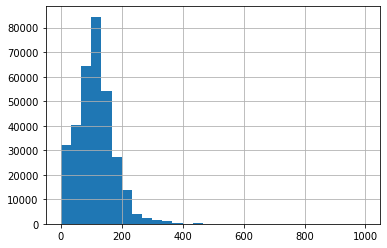

In [19]:
data[data['Power']<1000]['Power'].hist(bins = 30);

In [20]:
#Количество строк с мощностью меньше 10 и больше 500
len(data[(data['Power']>500) | (data['Power']<10)]['Power'])

31797

Мощность меньше 10 и больше 500 - аномальные значения. Удаляем.

In [21]:
data = data[(data['Power']<500) & (data['Power']>10)]

### Пропущенные значения

In [22]:
# Проверяем уникальные значения Price
data['Repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

В столбцах VehicleType, Gearbox, Model, FuelType, Repaired заменим пропущенные значения **unknown**

In [23]:
# Заполняем пропущенные значения
def fill(column):
    for i in column:
        data[i] = data[i].fillna('unknown')
        
fill(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired'])

In [24]:
# Проверяем пропущенные значения
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('YlOrRd')

,0
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
FuelType,0.000000
Brand,0.000000
Repaired,0.000000


### Проверяем полные дубликаты

In [25]:
data.duplicated().sum()

38962

Полные дубликаты появились, мне кажется, потому что убрали столбцы с датами и индексами, поэтому некоторые строки начали совпадать. Это данные для разных машин.

In [26]:
# Удаляем. Старые индексы обновляем.
data = data.drop_duplicates().reset_index(drop=True)

In [27]:
data.duplicated().sum()

0

**Вывод:**

В результате подготовки данных удалены столбцы: **NumberOfPictures, DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen**

В столбцах **Price и Power** удалены аномальные значения.

В столбцах **VehicleType, Gearbox, Model, FuelType, Repaired** пропущенные значения заменены на **unknown**


## Обучение моделей

### Подготовка выборки для обучения моделей

#### Разделение на выборки

In [28]:
# Зададим RandomState
RANDOMSTATE = 505784

# Разбиваем выборку в соотношении 60/20/20. 
train, valid, test = np.split(data.sample(frac=1, random_state=RANDOMSTATE), [int(.6*len(data)), int(.8*len(data))])

# Проверяем сколько строк и столбцов в полученных датасетах
print('Размер обучающей выборки - {:.0%}'.format(train.shape[0] / data.shape[0]))
print('Размер валидационной выборки- {:.0%}'.format(valid.shape[0] / data.shape[0]))
print('Размер тестовой выборки- {:.0%}'.format(test.shape[0] / data.shape[0]))


Размер обучающей выборки - 60%
Размер валидационной выборки- 20%
Размер тестовой выборки- 20%


In [29]:
print('Проверяем размер обучающей выборки')
print(train.shape) 
print('Проверяем размер валидационной выборки')
print(valid.shape)
print('Проверяем размер тестовой выборки')
print(test.shape)

Проверяем размер обучающей выборки
(153304, 10)
Проверяем размер валидационной выборки
(51102, 10)
Проверяем размер тестовой выборки
(51102, 10)


#### Кодирование категоральных столбцов методами

In [30]:
# Рассмотрим количество параметров в категориях

train.select_dtypes(include=[object]).nunique(axis=0).sort_values(ascending=False)

Model          248
Brand           40
VehicleType      9
FuelType         8
Gearbox          3
Repaired         3
dtype: int64

В столбцах Model и Brand слишком много категорий. Для них будем использовать **Target encoding**. Для остальных категоральных столбцов - OneHotEncoder.

In [31]:
# Target encoding
target_encoder = ce.TargetEncoder(cols=['Model', 'Brand'])
target_encoder_train = target_encoder.fit_transform(train, y=train['Price'])
target_encoder_valid = target_encoder.transform(valid)
target_encoder_test = target_encoder.transform(test)
target_encoder_train.head(5) # выводим на экран закодированную обучающую выборку

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
120593,1800,bus,2005,manual,95,4672.693410,150000,gasoline,3548.672121,unknown
208321,17500,wagon,2012,manual,136,6345.387491,150000,gasoline,6814.189169,unknown
102521,1290,sedan,1999,manual,102,3772.899459,150000,petrol,6276.106023,no
153310,14500,coupe,2010,auto,190,3748.414771,150000,gasoline,6814.189169,no
123800,996,wagon,1996,manual,116,4877.580682,150000,petrol,5035.836616,no


In [32]:
# MEstimateEncoder для train
ME_encoder = ce.MEstimateEncoder(cols=['Model', 'Brand'])
ME_encoder.fit_transform(train, y=train['Price']).head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
120593,1800,bus,2005,manual,95,4673.522800,150000,gasoline,3548.802112,unknown
208321,17500,wagon,2012,manual,136,6345.068523,150000,gasoline,6814.049159,unknown
102521,1290,sedan,1999,manual,102,3773.542399,150000,petrol,6276.016151,no
153310,14500,coupe,2010,auto,190,3748.609319,150000,gasoline,6814.049159,no
123800,996,wagon,1996,manual,116,4877.600364,150000,petrol,5035.834309,no


**MEstimateEncoder** дает значения, похожие на **Target encoding**. Оставим **TargetEncoder** для дальнейшей работы.

In [33]:
# OneHotEncoder
ohe_encoder = ce.OneHotEncoder(cols=['VehicleType', 'FuelType', 'Gearbox', 'Repaired'])
ohe_encoder.fit(target_encoder_train)

train_encoder = ohe_encoder.transform(target_encoder_train)
valid_encoder = ohe_encoder.transform(target_encoder_valid)
test_encoder = ohe_encoder.transform(target_encoder_test)

train_encoder.head(5)

,Price,VehicleType_1,VehicleType_2,VehicleType_3,VehicleType_4,VehicleType_5,VehicleType_6,VehicleType_7,VehicleType_8,VehicleType_9,...,FuelType_3,FuelType_4,FuelType_5,FuelType_6,FuelType_7,FuelType_8,Brand,Repaired_1,Repaired_2,Repaired_3
120593,1800,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3548.672121,1,0,0
208321,17500,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6814.189169,1,0,0
102521,1290,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,6276.106023,0,1,0
153310,14500,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,6814.189169,0,1,0
123800,996,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5035.836616,0,1,0


In [34]:
# Целевой признак  Price — цена
target_train = train_encoder['Price']
features_train = train_encoder.drop(['Price'], axis=1)

target_valid = valid_encoder['Price']
features_valid = valid_encoder.drop(['Price'], axis=1)

target_test = test_encoder['Price']
features_test = test_encoder.drop(['Price'], axis=1)

#### Масштабирование признаков

In [35]:
# Масштабирование признаков 
scaler = StandardScaler()
scaler.fit(features_train) 
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

### Дерево решений

In [36]:
%%time
#Построим модель для дерева решений

best_RMSE = 4000
best_depth = 0
best_samples_split = 2


for depth in range(2, 10):
    for samples_split in range(2,15):
    
        model = DecisionTreeRegressor(random_state=RANDOMSTATE, max_depth=depth, min_samples_split = samples_split) 
        model.fit(features_train, target_train) # обучаем модель на обучающей выборке
    
        predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке

      
        RMSE = mean_squared_error(target_valid, predictions_valid)**0.5
        print("RMSE:", RMSE, "Глубина дерева:", depth,"min_samples_split:", samples_split)

        if RMSE < best_RMSE:
            best_depth = depth
            best_RMSE = RMSE
            best_samples_split = samples_split

print()
print("RMSE:", best_RMSE, "Глубина дерева:", best_depth, "min_samples_split:", best_samples_split)

RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 2
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 3
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 4
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 5
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 6
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 7
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 8
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 9
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 10
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 11
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 12
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 13
RMSE: 3261.89550280586 Глубина дерева: 2 min_samples_split: 14
RMSE: 2991.6666359826195 Глубина дерева: 3 min_samples_split: 2
RMSE: 2991.6666359826195 Глубина дерева: 3 min_samples_split: 3
RMSE: 2991.6666359826195 Глубина дерева: 3 min_samples_split:

### Случайный лес

In [37]:
%%time
#Построим модель для случайного леса

best_RMSE = 4000
best_est = 0
best_depth = 0

for est in range(10, 13):
    for depth in range(10, 20):
        model = RandomForestRegressor(random_state=RANDOMSTATE, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) # обучаем модель на обучающей выборке
    
        predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке

      
        RMSE = mean_squared_error(target_valid, predictions_valid)**0.5
        print("RMSE:", RMSE, "Количество деревьев:", est, "Глубина дерева:", depth)

        if RMSE < best_RMSE:
            best_est = est
            best_depth = depth
            best_RMSE = RMSE

print()
print("RMSE:", best_RMSE, "Количество деревьев:", best_est,  "Глубина дерева:", best_depth)

RMSE: 1845.9780482234332 Количество деревьев: 10 Глубина дерева: 10
RMSE: 1791.310776318411 Количество деревьев: 10 Глубина дерева: 11
RMSE: 1751.7859077634816 Количество деревьев: 10 Глубина дерева: 12
RMSE: 1723.5680379514936 Количество деревьев: 10 Глубина дерева: 13
RMSE: 1700.9507673963508 Количество деревьев: 10 Глубина дерева: 14
RMSE: 1687.8119655705254 Количество деревьев: 10 Глубина дерева: 15
RMSE: 1680.000711390171 Количество деревьев: 10 Глубина дерева: 16
RMSE: 1678.9458371723356 Количество деревьев: 10 Глубина дерева: 17
RMSE: 1678.8663972804418 Количество деревьев: 10 Глубина дерева: 18
RMSE: 1680.1299071035091 Количество деревьев: 10 Глубина дерева: 19
RMSE: 1843.3663180383344 Количество деревьев: 11 Глубина дерева: 10
RMSE: 1788.2232827541404 Количество деревьев: 11 Глубина дерева: 11
RMSE: 1747.8447089797723 Количество деревьев: 11 Глубина дерева: 12
RMSE: 1718.5428206241124 Количество деревьев: 11 Глубина дерева: 13
RMSE: 1696.176148983199 Количество деревьев: 11 Гл

### Линейная регрессия

In [38]:
%%time
#Построим модель для Линейной регрессии

model = LinearRegression()
model.fit(features_train, target_train) # обучаем модель на обучающей выборке
    
predictions_valid = model.predict(features_valid) # предсказания модели на валидационной выборке     
RMSE = mean_squared_error(target_valid, predictions_valid)**0.5

print("RMSE:", RMSE)

RMSE: 2786.7404506855123
CPU times: user 304 ms, sys: 223 ms, total: 527 ms
Wall time: 515 ms


### Регрессия LightGBM

In [39]:
%%time
#Построим модель для регрессии LightGBM
best_RMSE = 4000
best_depth = 0
best_leaves = 0

for depth in range(10, 14, 2):
    for leaves in range(35, 37):
        model = lgb.LGBMRegressor(num_leaves = leaves,
                                  max_depth = depth,
                                  random_state=RANDOMSTATE,
                                  metric='rmse',
                                  task='train', 
                                  objective='regression',
                                  learning_rate=0.2,
                                  verbose=-1)


        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        RMSE = mean_squared_error(target_valid, predictions_valid)**0.5

        print("RMSE:", RMSE, "Количество листьев:", leaves,  "Глубина дерева:", depth)
        
        if RMSE < best_RMSE:
            best_leaves = leaves
            best_depth = depth
            best_RMSE = RMSE

print()
print("RMSE:", best_RMSE, "Количество листьев:", best_leaves,  "Глубина дерева:", best_depth)

RMSE: 1630.8860000990644 Количество листьев: 35 Глубина дерева: 10
RMSE: 1634.7360986750477 Количество листьев: 36 Глубина дерева: 10
RMSE: 1632.4251463513733 Количество листьев: 35 Глубина дерева: 12
RMSE: 1635.0901329038995 Количество листьев: 36 Глубина дерева: 12

RMSE: 1630.8860000990644 Количество листьев: 35 Глубина дерева: 10
CPU times: user 28min 13s, sys: 37.4 s, total: 28min 50s
Wall time: 29min 7s


**Вывод:**

Сравним полученные модели:

| |Дерево решений  	|Случайный лес  	|Линейная регрессия| LightGBM|    
|:---	|:---:	|:---:	|:---:	|:---:	|
|RMSE 	|1985.116998876751 	|1667.963195762331	|2786.7404506855123 |  1630.8860000990644|
|Время 	|29.3 s	|2min 25s|515 ms  |  29min 7s |

Наилучшее значение RMSE показала модель **LightGBM** - 1630.8860000990644, но это самая медленная модель. Быстрее всех - Линейная регрессия(515 ms секунды), но дает худший результат по RMSE 2786.7404506855123.

## Анализ моделей

Наилучшее значение RMSE получили для модели LightGBM. 

### Проверим лучшую модель на тестовой выборке

In [40]:
model = lgb.LGBMRegressor(num_leaves = 35,
                            max_depth = 10,
                            random_state=RANDOMSTATE,
                            metric='rmse',
                            task='train', 
                            objective='regression',
                            learning_rate=0.2,
                            verbose=-1)


model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
RMSE = mean_squared_error(target_test, predictions_test)**0.5

print("RMSE:", RMSE, "Количество листьев:", 35,  "Глубина дерева:", 10)

RMSE: 1626.7120985913086 Количество листьев: 35 Глубина дерева: 10


**Вывод:**

RMSE  на тестовой выборке - 1626.7120985913086. Немного меньше, чем на валидационной выборке. Модель нам подходит.

## Итоговые выводы

В результате подготовки данных были обнаружены и удалены 4 полных дубликата.

Удалены аномальные значения в столбцах: **RegistrationYear, Price и Power**.

В столбцах **VehicleType, Gearbox, Model, FuelType, Repaired** заменены пропущенные значения на **unknown**.

Удалены столбцы, не влияющие на цену: **NumberOfPictures, DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen**

Исследуемые модели:

- Дерево решений
- Случайный лес
- Линейная регрессия
- LightGBM

Наилучшее значение RMSE показала модель LightGBM - 1630.8860000990644, но это самая медленная модель. Быстрее всех - Линейная регрессия(515 ms секунды), но дает худший результат по RMSE 2786.7404506855123.

RMSE на тестовой выборке модели **LightGBM** - 1626.7120985913086. Немного меньше, чем на валидационной выборке.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей